In [5]:
import sys
sys.path.append('../../code/')

In [6]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis
from libs import helpers
from postprocessing import bias

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
aps_os_data_tar_gz = '../../data/final_dataset.tar.gz'
aps_data_dir = '../../data/aps_20240130_2e52fdd7260ea462878821948a2a463ed9acb58a'

In [72]:
df_publication_topic = io.read_csv(io.path_join(aps_data_dir, constants.APS_PUBLICTION_TOPICS))
df_disciplines = io.read_csv(io.path_join(aps_data_dir, constants.APS_DISCIPLINES_FN))
df_topic_types = io.read_csv(io.path_join(aps_data_dir, constants.APS_TOPIC_TYPES_FN))
df_authorships = io.read_csv(io.path_join(aps_data_dir, constants.APS_AUTHORSHIPS_FN))
df_author_names = io.read_csv(io.path_join(aps_data_dir, constants.APS_AUTHOR_NAMES_FN))
print("1a. df_authorships: ", df_authorships.shape, df_authorships.id_author_name.nunique())

# APS OA data
df_author_mapping = io.read_file_from_tar_gz_as_dataframe(aps_os_data_tar_gz, constants.APS_OA_AUTHORS_MAPPING_FN)
df_author_demographics = io.read_file_from_tar_gz_as_dataframe(aps_os_data_tar_gz, constants.APS_OA_AUTHORS_DEMOGRAPHICS_FN)
df_author_demographics.rename(columns={'id_author':'id_author_oa'}, inplace=True)
print("1b. df_author_mapping: ", df_author_mapping.shape, df_author_mapping.id_author_aps.nunique())

# mergins
df_authorships = df_authorships.merge(df_author_names, on='id_author_name', how='left')
print("2. df_authorships: ", df_authorships.shape, df_authorships.id_author_name.nunique())

df_authorships = df_authorships.merge(df_publication_topic, on='id_publication', how='left')
print("3. df_authorships: ", df_authorships.shape, df_authorships.id_author_name.nunique())

df_authorships = df_authorships.merge(df_disciplines, left_on='id_topic', right_on='id_discipline', how='left')
print("4. df_authorships: ", df_authorships.shape, df_authorships.id_author_name.nunique())

df_author_mapping = df_author_mapping.merge(df_authorships, right_on='id_author', left_on='id_author_aps', how='left')
print("5. df_author_mapping: ", df_author_mapping.shape, df_author_mapping.id_author_aps.nunique())

df_author_mapping = df_author_mapping.merge(df_author_demographics, on='id_author_oa', how='left')
print("6. df_author_mapping: ", df_author_mapping.shape, df_author_mapping.id_author_aps.nunique())

1a. df_authorships:  (2385375, 3) 940473
1b. df_author_mapping:  (918147, 4) 867973
2. df_authorships:  (2385375, 6) 940473
3. df_authorships:  (4695617, 9) 940473
4. df_authorships:  (4695617, 12) 940473
5. df_author_mapping:  (7186302, 16) 867973
6. df_author_mapping:  (7186302, 35) 867973


In [118]:
def clean_data(df, disciplines=True):
    ineq = '==' if disciplines else '!=' 
    df_data = df.query(f"id_topic_type {ineq} @constants.APS_TOPIC_DISCIPLINE_ID").copy()
    cols = ['id_discipline','label','id_author_oa'] if disciplines else ['id_author_oa']
    df_data.drop_duplicates(subset=cols, inplace=True)
    df_data = df_data[['id_author_oa', 'gender', 'ethnicity'] + (['label'] if disciplines else [])]
    return df_data

def calculate_basic_stats(df):
    # Calculate counts for gender
    gender_counts = df["gender"].value_counts().rename("gender_count")
    gender_fractions = (df["gender"].value_counts(normalize=True) * 100).rename("gender_fraction")
    stats_gender = io.pd.concat([gender_counts, gender_fractions], axis=1)

    # Calculate counts for ethnicity
    ethnicity_counts = df["ethnicity"].value_counts().rename("ethnicity_count")
    ethnicity_fractions = (df["ethnicity"].value_counts(normalize=True) * 100).rename("ethnicity_fraction")
    stats_ethnicity = io.pd.concat([ethnicity_counts, ethnicity_fractions], axis=1)
    return stats_gender, stats_ethnicity

def calculate_stats_by_discipline(df):
    # Calculate unique authors per discipline
    unique_authors = df.groupby(["label"])["id_author_oa"].nunique().rename("unique_authors")

    # Gender stats: unique counts and fractions
    gender_stats = (
        df.groupby(["label", "gender"])["id_author_oa"]
        .nunique()
        .unstack(fill_value=0)
        .rename_axis(None, axis=1)
    )
    gender_fractions = gender_stats.div(gender_stats.sum(axis=1), axis=0)

    # Ethnicity stats: unique counts and fractions
    ethnicity_stats = (
        df.groupby(["label", "ethnicity"])["id_author_oa"]
        .nunique()
        .unstack(fill_value=0)
        .rename_axis(None, axis=1)
    )
    ethnicity_fractions = ethnicity_stats.div(ethnicity_stats.sum(axis=1), axis=0)

    # Combine results into a single DataFrame
    result = io.pd.concat(
        {
            "unique_authors": unique_authors,
            "gender_counts": gender_stats,
            "gender_fractions": gender_fractions,
            "ethnicity_counts": ethnicity_stats,
            "ethnicity_fractions": ethnicity_fractions,
        },
        axis=1
    )
    return result

In [120]:
### NOT IN DISCIPLINES
df_data_not = clean_data(df_author_mapping, False)
result_not_g, result_not_e = calculate_basic_stats(df_data_not)
df_data_not.shape, result_not_g.shape, result_not_e.shape

((430197, 3), (4, 2), (5, 2))

In [171]:
### DISCIPLINES:
df_data_in = clean_data(df_author_mapping, True)
result_in = calculate_stats_by_discipline(df_data_in)
df_data_in.shape, result_in.shape

((331194, 4), (17, 19))

In [196]:
def get_data_by_attribute_and_metric(df, attribute, metric):
    #attribute = gender, ethnicity
    #metric = counts, fractions
    cols_2 = [('label','')] + [(c,v) for c, v in result_in.columns if c.startswith(attribute) and c.endswith(metric)]
    cols_1 = ['label'] + [v for c, v in result_in.columns if c.startswith(attribute) and c.endswith(metric)]
    result = result_in.reset_index()
    result = result[cols_2]
    result.columns = cols_1
    result.set_index('label', inplace=True)
    result = result[constants.GENDER_LIST]
    return result

In [264]:
result_in

unique_authors gender_counts         \
                                      unique_authors        Female   Male   
label                                                                       
Accelerators & Beams                            9253           716   4165   
Atomic, Molecular & Optical                    41767          3015  17717   
Biological Physics                              8116           876   3675   
Condensed Matter & Materials Physics           86319          7406  36819   
Fluid Dynamics                                 14565          1148   6402   
General Physics                                19842          1259   8381   
Gravitation, Cosmology & Astrophysics          15791          1507   7669   
Interdisciplinary Physics                      14149          1132   6145   
Networks                                        5126           380   2051   
Nonlinear Dynamics                             16063          1072   7015   
Nuclear Physics                                17091          1432   6539   
Particles & Fields                             21934          1674  10010   
Physics Education Research                      1182           292    497   
Plasma Physics                                  8142           483   3309   
Polymers & Soft Matter                         11111          1113   5156   
Quantum Information                            20745          1325   8361   
Statistical Physics                            19998          1576   9178   

                                                     gender_fractions  \
                                      Unisex Unknown           Female   
label                                                                   
Accelerators & Beams                    1212    3160         0.077380   
Atomic, Molecular & Optical             5562   15463         0.072203   
Biological Physics                      1074    2487         0.107988   
Condensed Matter & Materials Physics    8749   33327         0.085816   
Fluid Dynamics                          2026    4986         0.078835   
General Physics                         3221    6976         0.063467   
Gravitation, Cosmology & Astrophysics   1480    5130         0.095464   
Interdisciplinary Physics               1979    4888         0.080034   
Networks                                 958    1737         0.074132   
Nonlinear Dynamics                      2353    5620         0.066750   
Nuclear Physics                         2000    7119         0.083792   
Particles & Fields                      2592    7656         0.076327   
Physics Education Research               133     260         0.247039   
Plasma Physics                          1087    3262         0.059329   
Polymers & Soft Matter                  1246    3594         0.100189   
Quantum Information                     3488    7565         0.063889   
Statistical Physics                     2542    6699         0.078820   

                                                                     \
                                           Male    Unisex   Unknown   
label                                                                 
Accelerators & Beams                   0.450124  0.130985  0.341511   
Atomic, Molecular & Optical            0.424288  0.133199  0.370309   
Biological Physics                     0.453033  0.132396  0.306583   
Condensed Matter & Materials Physics   0.426635  0.101378  0.386172   
Fluid Dynamics                         0.439637  0.139129  0.342398   
General Physics                        0.422493  0.162373  0.351666   
Gravitation, Cosmology & Astrophysics  0.485810  0.093754  0.324971   
Interdisciplinary Physics              0.434460  0.139918  0.345588   
Networks                               0.400117  0.186890  0.338861   
Nonlinear Dynamics                     0.436800  0.146513  0.349938   
Nuclear Physics                        0.382621  0.117028  0.416559   
Particles & Fields                     0.4

/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/dev/../../code/libs/vis.py:29: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


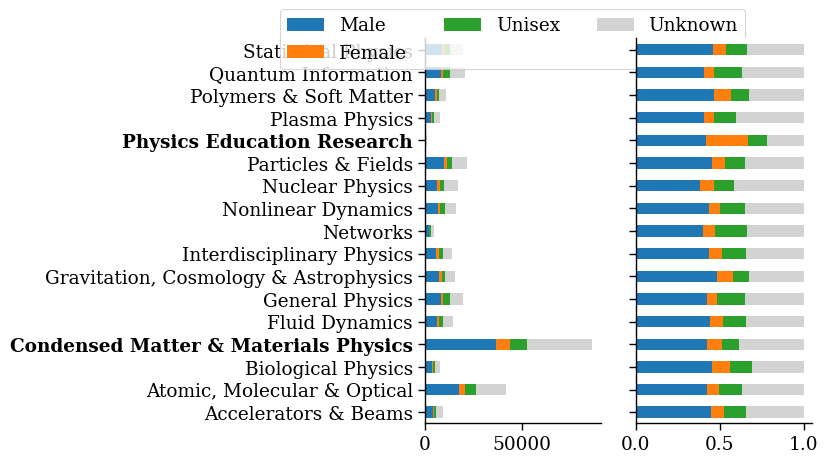

In [263]:
from operator import le
from matplotlib import legend


fig, axes = vis.plt.subplots(1, 2, figsize=(20, 6), sharey=True, sharex=False)

# counts
ax = axes[0]
df_gender_c = get_data_by_attribute_and_metric(result_in, 'gender', 'counts')
ax = df_gender_c.plot.barh(stacked=True, figsize=(7, 5), color=constants.GENDER_COLOR_DICT.values(), ax=ax, legend=False)   
ax.set_ylabel('')
ax.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.1))

# fractions
ax = axes[1]
df_gender_f = get_data_by_attribute_and_metric(result_in, 'gender', 'fractions')
ax = df_gender_f.plot.barh(stacked=True, figsize=(5, 5), color=constants.GENDER_COLOR_DICT.values(), ax=ax, legend=False)
ax.set_ylabel('')

# Make specific ytick labels bold
bold_labels = ["Physics Education Research", "Condensed Matter & Materials Physics"]  # Specify labels to make bold
for label in axes[0].get_yticklabels():
    if label.get_text() in bold_labels:
        label.set_fontweight("bold")  # Make the label bold


# Layout adjustments
# vis.plt.tight_layout()
vis._finish_plot(fig, None)
vis.plt.show()
vis.plt.close()